In [1]:
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
df= pd.read_csv("Dataset_de_200_Comunidades_para_Analise_Ambiental2.csv")

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [27]:
from sklearn.preprocessing import StandardScaler

# Converter colunas Sim/Não para numéricas
df['Presença de Escola'] = df['Presença de Escola (Sim/Não)'].map({'Sim': 1, 'Não': 0})
df['Presença de Saúde'] = df['Presença de Unidade de Saúde (Sim/Não)'].map({'Sim': 1, 'Não': 0})

# Selecionar colunas numéricas relevantes
colunas_numericas = [
    'Índice de Desmatamento (%)',
    'Acesso à Água Potável (%)',
    'Cobertura Vegetal (%)',
    'Renda Média Mensal (R$)',
    'Densidade Populacional (hab/km²)',
    'Frequência de Queimadas (ano)',
    'Distância de Área Urbana (km)',
    'Presença de Escola',
    'Presença de Saúde',
    'Latitude', 
    'Longitude']

# Normalizar os dados
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df[colunas_numericas])

In [28]:
from sklearn.decomposition import PCA

# Aplicar PCA (preservando 95% da variância)
pca = PCA(n_components=0.95, random_state=42)
componentes_principais = pca.fit_transform(dados_normalizados)

# Criar DataFrame com os componentes
df_pca = pd.DataFrame(componentes_principais, columns=[f'PC{i+1}' for i in range(componentes_principais.shape[1])])

print(f"Variância explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Número de componentes selecionados: {pca.n_components_}")

Variância explicada por cada componente: [0.13255018 0.11527067 0.1094036  0.10477658 0.09524402 0.09363416
 0.08247668 0.0770769  0.07146552 0.06745226 0.05064944]
Número de componentes selecionados: 11


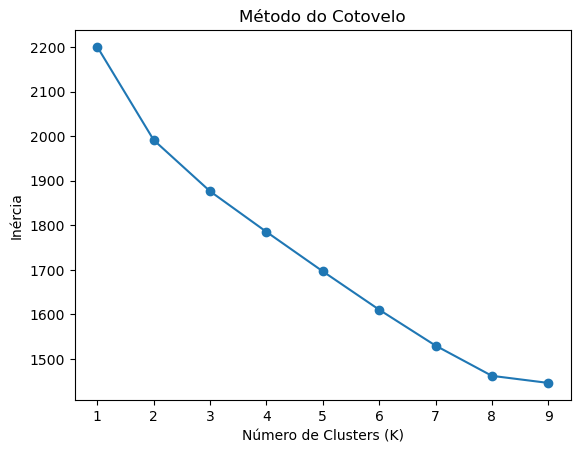

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Método do Cotovelo para definir K ideal
inercia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 10), inercia, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

# Escolher K com base no gráfico (ex.: K=3)
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['Cluster_PCA'] = kmeans.fit_predict(df_pca)

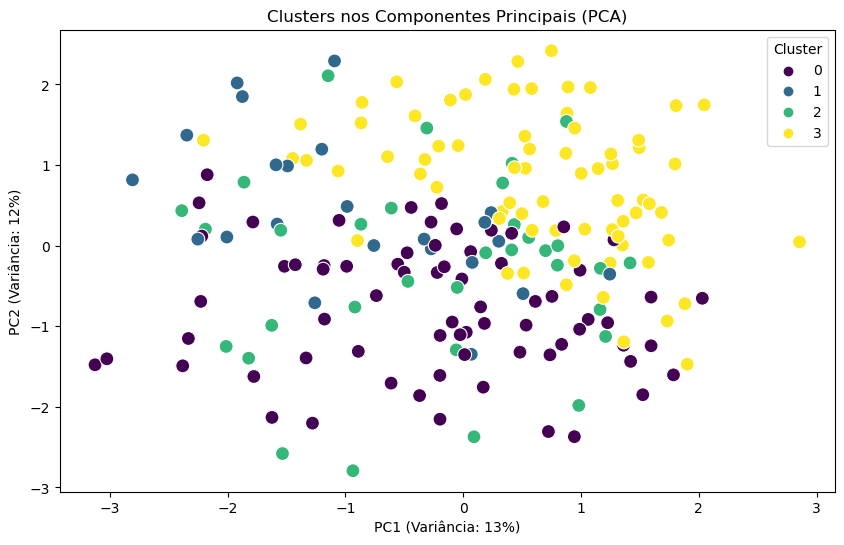

In [40]:
# Plotar os clusters nos dois primeiros componentes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_pca['PC1'], 
    y=df_pca['PC2'], 
    hue=df['Cluster_PCA'], 
    palette='viridis',
    s=100
)
plt.title('Clusters nos Componentes Principais (PCA)')
plt.xlabel(f'PC1 (Variância: {pca.explained_variance_ratio_[0]:.0%})')
plt.ylabel(f'PC2 (Variância: {pca.explained_variance_ratio_[1]:.0%})')
plt.legend(title='Cluster')
plt.show()

In [36]:
# Criar DataFrame com os pesos das variáveis originais
df_cargas = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=colunas_numericas
)

# Visualizar as 3 variáveis mais relevantes por componente
for pc in df_cargas.columns:
    print(f"\nComponente {pc}:")
    print(df_cargas[pc].abs().sort_values(ascending=False).head(3))


Componente PC1:
Latitude                     0.568970
Longitude                    0.537138
Acesso à Água Potável (%)    0.455461
Name: PC1, dtype: float64

Componente PC2:
Cobertura Vegetal (%)               0.61824
Densidade Populacional (hab/km²)    0.50869
Frequência de Queimadas (ano)       0.45848
Name: PC2, dtype: float64

Componente PC3:
Presença de Saúde            0.595850
Presença de Escola           0.591119
Acesso à Água Potável (%)    0.268979
Name: PC3, dtype: float64

Componente PC4:
Índice de Desmatamento (%)       0.659956
Distância de Área Urbana (km)    0.429761
Frequência de Queimadas (ano)    0.386287
Name: PC4, dtype: float64

Componente PC5:
Renda Média Mensal (R$)          0.782287
Distância de Área Urbana (km)    0.480601
Acesso à Água Potável (%)        0.295645
Name: PC5, dtype: float64

Componente PC6:
Longitude                    0.504869
Presença de Saúde            0.495636
Acesso à Água Potável (%)    0.393279
Name: PC6, dtype: float64

Componente PC7:

In [41]:
# Calcular médias por cluster
df_analise = df.groupby('Cluster_PCA')[colunas_numericas].mean().reset_index()

# Ordenar clusters pelo pior desempenho (ex.: maior desmatamento + menor acesso à água)
df_analise['Score_Risco'] = (
    df_analise['Índice de Desmatamento (%)'] * 0.4 +
    (100 - df_analise['Acesso à Água Potável (%)']) * 0.3 +
    df_analise['Frequência de Queimadas (ano)'] * 0.3
)

df_analise = df_analise.sort_values('Score_Risco', ascending=False)
print(df_analise)

   Cluster_PCA  Índice de Desmatamento (%)  Acesso à Água Potável (%)  \
0            0                   53.097183                  64.888732   
2            2                   50.785294                  66.091176   
1            1                   31.939130                  50.295652   
3            3                   45.644444                  76.730556   

   Cobertura Vegetal (%)  Renda Média Mensal (R$)  \
0              34.518310              1561.816901   
2              44.179412              1564.617647   
1              50.126087              1753.130435   
3              66.473611              1645.805556   

   Densidade Populacional (hab/km²)  Frequência de Queimadas (ano)  \
0                         66.739437                       4.647887   
2                         91.111765                       4.852941   
1                         74.273913                       8.521739   
3                         96.518056                       6.152778   

   Distância de Á

In [43]:
import folium

# Definir cores: vermelho para o pior cluster (Cluster 2 no exemplo)
cores_clusters = {0: 'red', 1: 'orange', 2: 'green'}

# Criar mapa
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=cores_clusters[row['Cluster_PCA']],
        fill=True,
        popup=f"""
        Cluster: {row['Cluster_PCA']}<br>
        Município: {row['Município']}<br>
        Desmatamento: {row['Índice de Desmatamento (%)']}%<br>
        Queimadas: {row['Frequência de Queimadas (ano)']} <br>
        Renda: R${row['Renda Média Mensal (R$)']:.2f}
        """
    ).add_to(mapa)
mapa
#mapa.save('clusters_pca.html')